## Keras MNIST Recognition
Examples of image recognition on the MNIST dataset using Keras using Feed forward network, CNN and transfer learning.

This notebook also contains examples on the use of Tensorboard and how to visualise neural networks.

Some things that we don't cover are:

* Early stopping to automatically exit training when no improvements are seen - see keras.callbacks.EarlyStopping
* L1 & L2 Regularisation on the layers

In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from scipy.misc import imread
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
from keras import activations
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt

C:\Applications\Miniconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Some shared functions

In [26]:
def score_model(model, X_test, y_test):
    """ 
    Evaluate and show a models scores 
    
    Args: 
        model: The model to score 
        X_test: test set
        y_test: labels for the test set
        
    Returns: 
    
    """
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    print("Baseline Error: %.2f%%" % (100-score[1]*100))

def plot_model_accuracy_loss(history):
    """ 
    Show plots of train v's test accuracy and loss. 
    
    Args: 
        history: history returned from fitting a model 
        
    Returns: 
    
    """
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
   
    # summarize history for loss     
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  

Create model and print model summary. We see that input is 224x224 pixels with 3 channels and output is 1000 classes

In [3]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


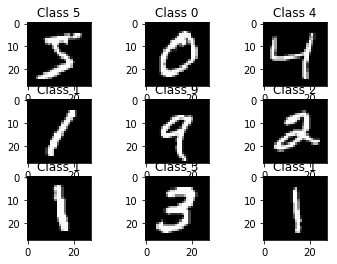

In [5]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [6]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Finally, the output variable is an integer from 0 to 9. As this is a multi-class classification problem we need to one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in np_utils.to_categorical() helper function in Keras.

In [7]:
# one hot encode outputs and save original classes
print(y_train.shape)
print(y_test.shape)
print(y_train[:10])
y_train_classes = y_train.copy()
y_test_classes = y_test.copy()
y_train = np_utils.to_categorical(y_train_classes)
y_test = np_utils.to_categorical(y_test_classes)
num_classes = y_test.shape[1]
print(y_train.shape)
print(y_test.shape)
print(y_train[:3])

(60000,)
(10000,)
[5 0 4 1 9 2 1 3 1 4]
(60000, 10)
(10000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Feed forward network

The training dataset is structured as a 3-dimensional array of (instance, image width and image height). Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector.

We can do this transform easily using the reshape() function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [8]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train_FF = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test_FF = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
print(X_train_FF.shape)
print(X_test_FF.shape)

(60000, 784)
(10000, 784)


We use a simple network with a single hidden layer with the same number of neurans as input features. A softmax activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model’s output prediction. Logarithmic loss is used as the loss function (called categorical_crossentropy in Keras) and the efficient ADAM gradient descent algorithm is used to learn the weights.

In [9]:
# define baseline model
def create_feed_forward_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
# build the model
model_FF = create_feed_forward_model()
print(model_FF.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None


Setup callback for tensor board logging. To start tensorboard, change to the folder containing the logs directory and run:

tensorboard --logdir=logs/

In [11]:
tf_callback_ff= keras.callbacks.TensorBoard(log_dir="logs/keras_mnist_ff/{}".format(time()), histogram_freq=1, write_graph=True, write_images=True)

Instructions for updating:
Use the retry module or similar alternatives.


Fit the model

In [12]:
history = model_FF.fit(X_train_FF, y_train, validation_data=(X_test_FF, y_test), epochs=10, batch_size=200, verbose=2, callbacks=[tf_callback_ff])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 5s - loss: 0.2819 - acc: 0.9201 - val_loss: 0.1395 - val_acc: 0.9590
Epoch 2/10
 - 5s - loss: 0.1104 - acc: 0.9679 - val_loss: 0.1005 - val_acc: 0.9705
Epoch 3/10
 - 5s - loss: 0.0718 - acc: 0.9789 - val_loss: 0.0778 - val_acc: 0.9760
Epoch 4/10
 - 5s - loss: 0.0500 - acc: 0.9858 - val_loss: 0.0736 - val_acc: 0.9758
Epoch 5/10
 - 5s - loss: 0.0364 - acc: 0.9897 - val_loss: 0.0613 - val_acc: 0.9804
Epoch 6/10
 - 5s - loss: 0.0263 - acc: 0.9932 - val_loss: 0.0671 - val_acc: 0.9789
Epoch 7/10
 - 5s - loss: 0.0194 - acc: 0.9952 - val_loss: 0.0602 - val_acc: 0.9802
Epoch 8/10
 - 5s - loss: 0.0139 - acc: 0.9970 - val_loss: 0.0621 - val_acc: 0.9800
Epoch 9/10
 - 5s - loss: 0.0101 - acc: 0.9980 - val_loss: 0.0680 - val_acc: 0.9790
Epoch 10/10
 - 5s - loss: 0.0081 - acc: 0.9985 - val_loss: 0.0650 - val_acc: 0.9810


Final evaluation of the model

In [27]:
score_model(model_FF, X_test_FF, y_test)

Test score: 0.06500244828998693
Test accuracy: 0.981
Baseline Error: 1.90%


In [28]:
score = model_FF.evaluate(X_test_FF, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print("Baseline Error: %.2f%%" % (100-score[1]*100))

Test score: 0.06500244828998693
Test accuracy: 0.981
Baseline Error: 1.90%


Plot accuracy and loss for train / test sets to see if more epochs would have helped and to ensure that we don't start overfitting.

Here we should probably have stopped after 4 epochs!

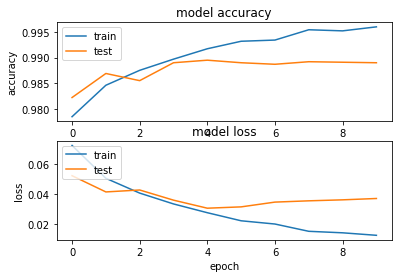

In [29]:
plot_model_accuracy_loss(history)

### Inspect the output
Manually inspect the output to check everything looks as expected

In [30]:
# The predict_classes function outputs the highest probability class# The pr 
# according to the trained classifier for each input example.
predicted_classes = model_FF.predict_classes(X_test_FF)

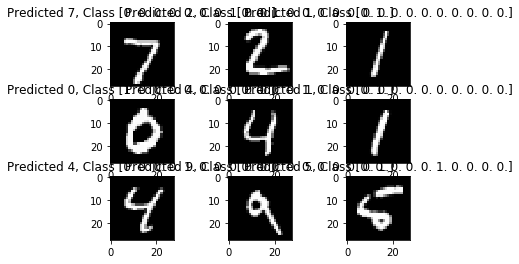

In [31]:
# Show some items we got right
correct_indices = np.nonzero(predicted_classes == y_test_classes)[0]

for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

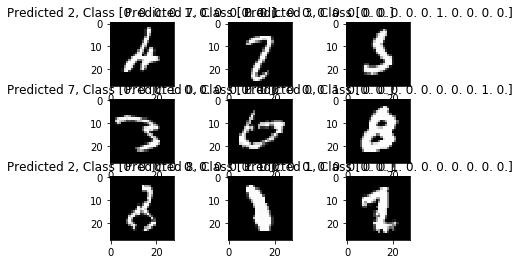

In [32]:
# Show some items we got wrong
incorrect_indices = np.nonzero(predicted_classes != y_test_classes)[0]

for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## Convolutional Neural Network
In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels].

In the case of RGB, the pixel dimension would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [33]:
# reshape to be [samples][pixels][width][height]
X_train_CNN = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_CNN = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
print(X_train_CNN.shape)
print(X_test_CNN.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


We create a simple CNN with the following layers:

* The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps of size 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [width][height][pixels].
* Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
* The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
* Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
* Next a fully connected layer with 128 neurons and rectifier activation function.
* Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

In [34]:
def create_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', name="Output"))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
# build the model
model_CNN = create_cnn_model()
print(model_CNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               589952    
_________________________________________________________________
Output (Dense)               (None, 10)                1290      
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
_________________________________________________________________
None

In [36]:
tf_callback_cnn = keras.callbacks.TensorBoard(log_dir="logs/keras_mnist_cnn/{}".format(time()), histogram_freq=1, write_graph=True, write_images=True)

Fit the model - note: tensorboard callback removed due to throwing an error.

In [37]:
history = model_CNN.fit(X_train_CNN, y_train, validation_data=(X_test_CNN, y_test), epochs=10, 
                        batch_size=200, verbose=2)#, callbacks=[tf_callback_cnn])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 35s - loss: 0.2380 - acc: 0.9323 - val_loss: 0.0817 - val_acc: 0.9757
Epoch 2/10
 - 35s - loss: 0.0743 - acc: 0.9777 - val_loss: 0.0533 - val_acc: 0.9832
Epoch 3/10
 - 36s - loss: 0.0504 - acc: 0.9847 - val_loss: 0.0519 - val_acc: 0.9829
Epoch 4/10
 - 37s - loss: 0.0413 - acc: 0.9868 - val_loss: 0.0381 - val_acc: 0.9871
Epoch 5/10
 - 37s - loss: 0.0334 - acc: 0.9894 - val_loss: 0.0374 - val_acc: 0.9875
Epoch 6/10
 - 41s - loss: 0.0278 - acc: 0.9912 - val_loss: 0.0371 - val_acc: 0.9869
Epoch 7/10
 - 41s - loss: 0.0220 - acc: 0.9929 - val_loss: 0.0416 - val_acc: 0.9868
Epoch 8/10
 - 36s - loss: 0.0202 - acc: 0.9936 - val_loss: 0.0310 - val_acc: 0.9902
Epoch 9/10
 - 37s - loss: 0.0169 - acc: 0.9945 - val_loss: 0.0366 - val_acc: 0.9878
Epoch 10/10
 - 36s - loss: 0.0132 - acc: 0.9958 - val_loss: 0.0357 - val_acc: 0.9897


Final evaluation of the model

In [38]:
score_model(model_CNN, X_test_CNN, y_test)

Test score: 0.03567284434780013
Test accuracy: 0.9897
Baseline Error: 1.03%


Plot accuracy and loss for train / test sets to see if more epochs would have helped and to ensure that we don't start overfitting

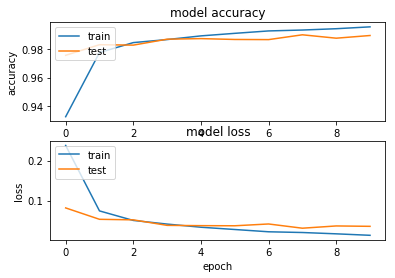

In [39]:
plot_model_accuracy_loss(history)

### Inspect the output
Manually inspect the output to check everything looks as expected

In [40]:
# The predict_classes function outputs the highest probability class# The pr 
# according to the trained classifier for each input example.
predicted_classes = model_CNN.predict_classes(X_test_CNN)

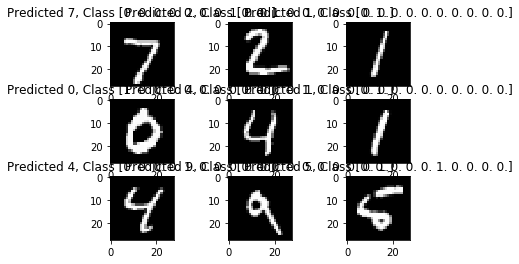

In [41]:
# Show some items we got right
correct_indices = np.nonzero(predicted_classes == y_test_classes)[0]

for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

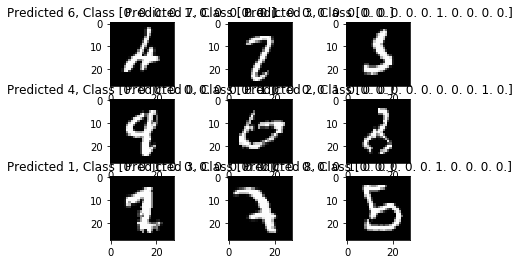

In [42]:
# Show some items we got wrong
incorrect_indices = np.nonzero(predicted_classes != y_test_classes)[0]

for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

### Repeat with Data Augmentation
Data augmentation rotates, shears, zooms, etc the image so that the model learns to generalize and not remember specific data. 

First we show an example of data augmentation in action - using rotation

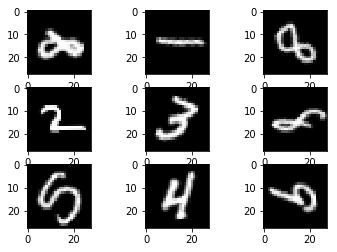

In [44]:
from keras.preprocessing.image import ImageDataGenerator
# define data preparation with features to test
datagen = ImageDataGenerator(rotation_range=90)
# fit parameters from data
datagen.fit(X_train_CNN)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train_CNN, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break # loop one batch only

For the actual dataset, we create batches so that we use less memory and train our model faster. Here we are using a batch size of 64, so the model will take 64 images at a time and train on them.

In [45]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3, height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()
batch_size = 64

In [46]:
train_generator = gen.flow(X_train_CNN, y_train, batch_size=batch_size)
test_generator = test_gen.flow(X_test_CNN, y_test, batch_size=batch_size)

In [47]:
model_CNN.fit_generator(train_generator, steps_per_epoch=60000//batch_size, epochs=10, 
                    validation_data=test_generator, validation_steps=10000//batch_size, verbose=2) #, callbacks=[tf_callback_cnn])


Epoch 1/10
 - 44s - loss: 0.1089 - acc: 0.9665 - val_loss: 0.0356 - val_acc: 0.9876
Epoch 2/10
 - 47s - loss: 0.0688 - acc: 0.9785 - val_loss: 0.0282 - val_acc: 0.9910
Epoch 3/10
 - 47s - loss: 0.0557 - acc: 0.9822 - val_loss: 0.0279 - val_acc: 0.9903
Epoch 4/10
 - 47s - loss: 0.0502 - acc: 0.9845 - val_loss: 0.0234 - val_acc: 0.9924
Epoch 5/10
 - 47s - loss: 0.0476 - acc: 0.9850 - val_loss: 0.0267 - val_acc: 0.9907
Epoch 6/10
 - 48s - loss: 0.0420 - acc: 0.9864 - val_loss: 0.0204 - val_acc: 0.9933
Epoch 7/10
 - 48s - loss: 0.0385 - acc: 0.9881 - val_loss: 0.0226 - val_acc: 0.9917
Epoch 8/10
 - 49s - loss: 0.0401 - acc: 0.9876 - val_loss: 0.0198 - val_acc: 0.9929
Epoch 9/10
 - 49s - loss: 0.0355 - acc: 0.9889 - val_loss: 0.0260 - val_acc: 0.9908
Epoch 10/10
 - 49s - loss: 0.0357 - acc: 0.9886 - val_loss: 0.0266 - val_acc: 0.9917


In [48]:
score_model(model_CNN, X_test_CNN, y_test)

Test score: 0.026584637854149332
Test accuracy: 0.9917
Baseline Error: 0.83%


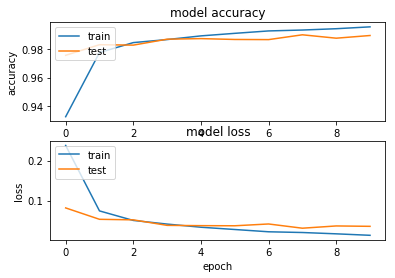

In [49]:
plot_model_accuracy_loss(history)

### Visualise The Trained Network
#### Feature Maps (Filters) for Convolutional Layer
By plotting the filters we can see what kind of features are being targeted.

Low level filters nearer the start of a network work as edge detectors, and as we go forther, they tend to capture high level concepts like objects and faces.

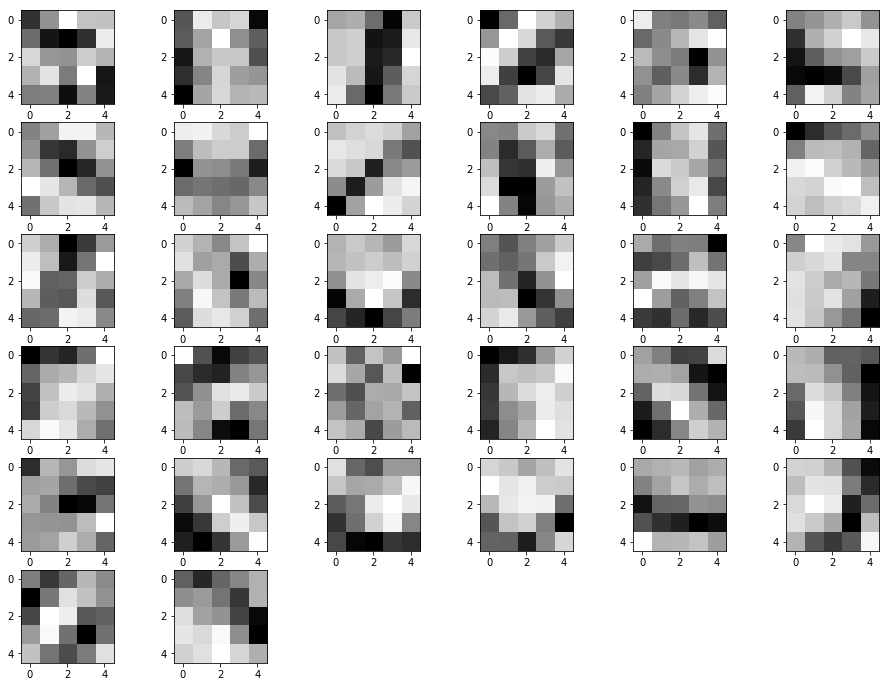

In [50]:
top_layer = model_CNN.layers[0]
fig=plt.figure(figsize=(16, 12))
for i in range(32):
    plt.subplot(6,6,i+1)
    plt.imshow(top_layer.get_weights()[0][:, :, :, i].squeeze(), cmap='gray')

#### Activation Maps
Generates the model input that maximizes the output of all filter_indices in the given layer_idx. This allows us to see what features / regions within the images are contributing to different classes being chosen.

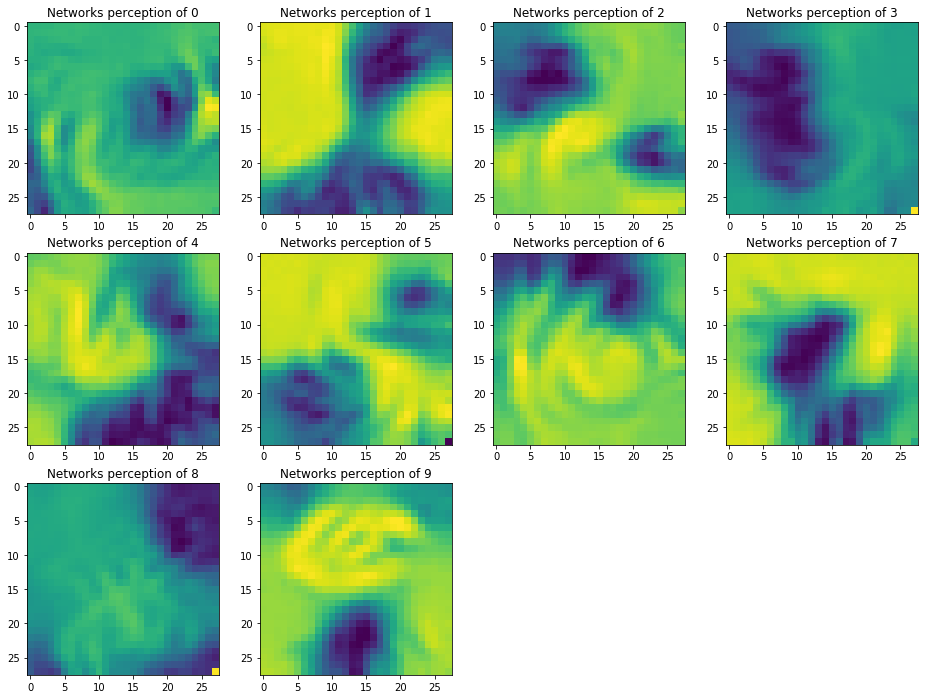

In [52]:
from vis.visualization import visualize_activation
from vis.utils import utils

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model_CNN, 'Output')

# Swap softmax with linear
model_CNN.layers[layer_idx].activation = activations.linear
model_CNN = utils.apply_modifications(model_CNN)

# plot activations on inputs that will trigger a particular class.
fig=plt.figure(figsize=(16, 12))
for output_class_idx in np.arange(10):
    plt.subplot(3,4,output_class_idx+1)
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model_CNN, layer_idx, filter_indices=output_class_idx, input_range=(0., 1.))
    #/plt.figure()
    plt.title('Networks perception of {}'.format(output_class_idx))
    plt.imshow(img[..., 0])

#### Saliency Maps
Highlights the salient image regions that contribute the most towards the output.

The concept of using saliency maps is pretty straight-forward – we compute the gradient of the output category with respect to the input image. This should tell us how the output category value changes with respect to a small change in the input image pixels. All the positive values in the gradients tell us that a small change to that pixel will increase the output value. Hence, visualizing these gradients, which are the same shape as the image, should provide some intuition of attention.

https://arxiv.org/pdf/1312.6034v2.pdf

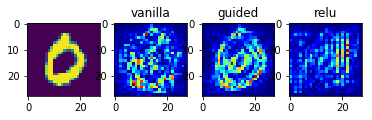

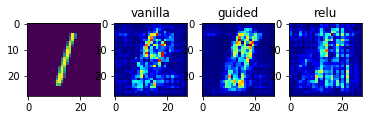

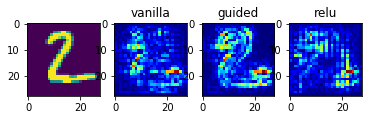

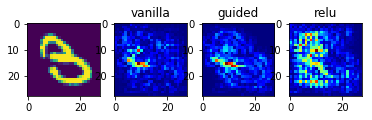

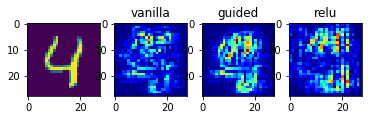

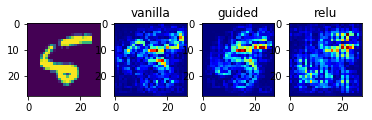

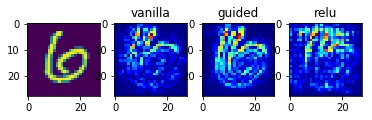

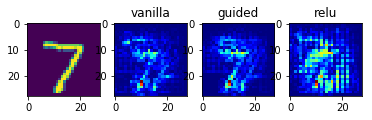

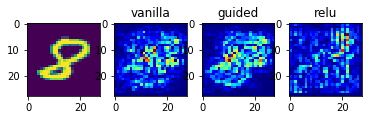

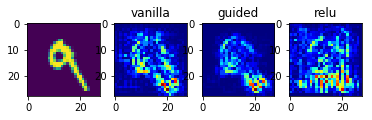

In [54]:
from vis.visualization import visualize_saliency
from vis.utils import utils

# This corresponds to the Dense linear layer.
for output_class_idx in np.arange(10): 
    indices = np.where(y_test[:, output_class_idx] == 1.)[0]
    idx = indices[0]
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(X_test[idx])
 
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model_CNN, layer_idx, filter_indices=output_class_idx, 
        seed_input=X_test_CNN[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier) 
        ax[i+1].imshow(grads, cmap='jet')

#### Gradient based Class Activations Maps
Class activation maps, or grad-CAM, is another way of visualizing what our model looks at while making predictions. Instead of using gradients with respect to the output, grad-CAM uses penultimate Convolutional layer output. This is done to utilize the spacial information that is being stored in the penultimate layer.

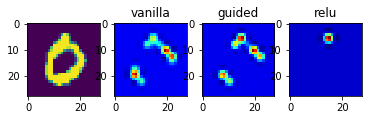

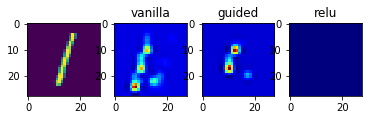

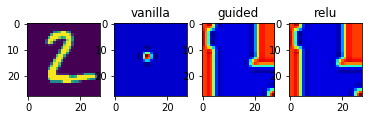

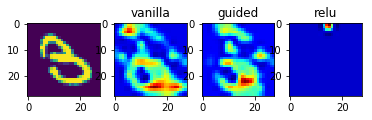

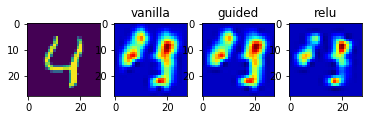

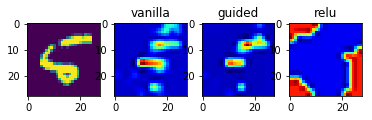

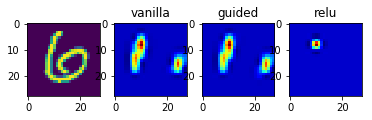

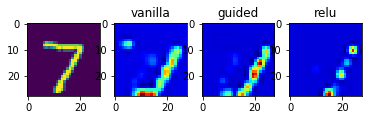

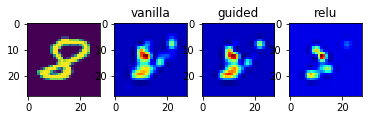

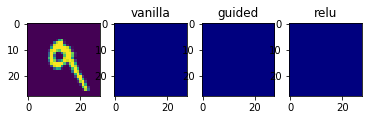

In [55]:
from vis.visualization import visualize_cam

# This corresponds to the Dense linear layer.
for output_class_idx in np.arange(10): 
    indices = np.where(y_test[:, output_class_idx] == 1.)[0]
    idx = indices[0]
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(X_test[idx])
 
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model_CNN, layer_idx, filter_indices=output_class_idx, 
        seed_input=X_test_CNN[idx], backprop_modifier=modifier) 
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier) 
        ax[i+1].imshow(grads, cmap='jet')

## More Advanced CNN Network
A more advanced convolutional network might add additional convolutional, max pooling and fully connected layers for example:

* Convolutional layer with 30 feature maps of size 5×5.
* Pooling layer taking the max over 2*2 patches.
* Convolutional layer with 15 feature maps of size 3×3.
* Pooling layer taking the max over 2*2 patches.
* Dropout layer with a probability of 20%.
* Flatten layer.
* Fully connected layer with 128 neurons and rectifier activation.
* Fully connected layer with 50 neurons and rectifier activation.
* Output layer.

In [ ]:
# define the larger model
def create_improved_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Transfer Learning
We can try transfer learning on a proven architecture. Note that we don't necessarily expect better results in this case as the domains are different and possibly not transferable. This is more to demonstrate the concept.

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image

Retrain the output dense layers only – Here we use vgg16 as a feature extractor. We then use these features and send them to dense layers which are trained according to our data set. The output layer is also replaced with our new softmax layer relevant to our problem. The output layer in a vgg16 is a softmax activation with 1000 categories. We remove this layer and replace it with a softmax layer of 10 categories. We just train the weights of these layers and try to identify the digits.

In [ ]:
# loading VGG16 model weights dropping the output layers
model = VGG16(weights='imagenet', include_top=False)
print(model.summary())

TODO
ref: https://github.com/flyyufelix/cnn_finetune

In [ ]:
# importing required libraries

from keras.models import Sequential
from scipy.misc import imread
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions
train=pd.read_csv("R/Data/Train/train.csv")
test=pd.read_csv("R/Data/test.csv")
train_path="R/Data/Train/Images/train/"
test_path="R/Data/Train/Images/test/"

from scipy.misc import imresize
# preparing the train dataset

train_img=[]
for i in range(len(train)):

    temp_img=image.load_img(train_path+train['filename'][i],target_size=(224,224))

    temp_img=image.img_to_array(temp_img)

    train_img.append(temp_img)

#converting train images to array and applying mean subtraction processing

train_img=np.array(train_img) 
train_img=preprocess_input(train_img)
# applying the same procedure with the test dataset

test_img=[]
for i in range(len(test)):

    temp_img=image.load_img(test_path+test['filename'][i],target_size=(224,224))

    temp_img=image.img_to_array(temp_img)

    test_img.append(temp_img)

test_img=np.array(test_img) 
test_img=preprocess_input(test_img)

# loading VGG16 model weights
model = VGG16(weights='imagenet', include_top=False)
# Extracting features from the train dataset using the VGG16 pre-trained model

features_train=model.predict(train_img)
# Extracting features from the train dataset using the VGG16 pre-trained model

features_test=model.predict(test_img)

# flattening the layers to conform to MLP input

train_x=features_train.reshape(49000,25088)
# converting target variable to array

train_y=np.asarray(train['label'])
# performing one-hot encoding for the target variable

train_y=pd.get_dummies(train_y)
train_y=np.array(train_y)
# creating training and validation set

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_x,train_y,test_size=0.3, random_state=42)

 

# creating a mlp model
from keras.layers import Dense, Activation
model=Sequential()

model.add(Dense(1000, input_dim=25088, activation='relu',kernel_initializer='uniform'))
keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)

model.add(Dense(500,input_dim=1000,activation='sigmoid'))
keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)

model.add(Dense(150,input_dim=500,activation='sigmoid'))
keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)

model.add(Dense(units=10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# fitting the model 

model.fit(X_train, Y_train, epochs=20, batch_size=128,validation_data=(X_valid,Y_valid))

 Freeze the weights of first few layers – Here what we do is we freeze the weights of the first 8 layers of the vgg16 network, while we retrain the subsequent layers. This is because the first few layers capture universal features like curves and edges that are also relevant to our new problem. We want to keep those weights intact and we will get the network to focus on learning dataset-specific features in the subsequent layers.

In [ ]:
from keras.models import Sequential
from scipy.misc import imread
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

from sklearn.metrics import log_loss

train=pd.read_csv("R/Data/Train/train.csv")
test=pd.read_csv("R/Data/test.csv")
train_path="R/Data/Train/Images/train/"
test_path="R/Data/Train/Images/test/"

from scipy.misc import imresize

train_img=[]
for i in range(len(train)):

    temp_img=image.load_img(train_path+train['filename'][i],target_size=(224,224))

    temp_img=image.img_to_array(temp_img)

    train_img.append(temp_img)

train_img=np.array(train_img) 
train_img=preprocess_input(train_img)

test_img=[]
for i in range(len(test)):

temp_img=image.load_img(test_path+test['filename'][i],target_size=(224,224))

    temp_img=image.img_to_array(temp_img)

    test_img.append(temp_img)

test_img=np.array(test_img) 
test_img=preprocess_input(test_img)


from keras.models import Model

def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):

    model = VGG16(weights='imagenet', include_top=True)

    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-1].outbound_nodes = []

          x=Dense(num_classes, activation='softmax')(model.output)

    model=Model(model.input,x)

#To set the first 8 layers to non-trainable (weights will not be updated)

          for layer in model.layers[:8]:

       layer.trainable = False

# Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

train_y=np.asarray(train['label'])

le = LabelEncoder()

train_y = le.fit_transform(train_y)

train_y=to_categorical(train_y)

train_y=np.array(train_y)

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.2, random_state=42)

# Example to fine-tune on 3000 samples from Cifar10

img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_classes = 10 
batch_size = 16 
nb_epoch = 10

# Load our model
model = vgg16_model(img_rows, img_cols, channel, num_classes)

model.summary()
# Start Fine-tuning
model.fit(X_train, Y_train,batch_size=batch_size,epochs=nb_epoch,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid))

# Make predictions
predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

# Cross-entropy loss score
score = log_loss(Y_valid, predictions_valid)